In [ ]:
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyr)
library(tidyverse)
library(ggpmisc)
library(mutspecdist)
library(patchwork)

In [ ]:
# study dataframes
Hiatt = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/Hiattdataframe.csv',
                 stringsAsFactors = FALSE, header = TRUE)

Hiatt$sex <- "male"

LeeSix = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/LeeSixdataframe.csv',
                 stringsAsFactors = FALSE, header = TRUE)

LeeSix <- LeeSix %>%
  rename("crypt_sample" = "subject_id",
         "donor" = "patient")
## Get cohort to match Hiatt
LeeSix <- LeeSix %>%
  mutate(cohort = ifelse(cohort_status == 'bowel_cancer_screening_Yes',
                         'carcinoma', "normal"))

## Get region to match Hiatt
LeeSix$region <- ifelse(grepl("Caecum", LeeSix$phenotype, ignore.case = TRUE),
                        "cecum",
                        ifelse(grepl("AC", LeeSix$phenotype, ignore.case = TRUE),
                               "asc_col",
                               ifelse(grepl("Sigmoid", LeeSix$phenotype,
                                            ignore.case = TRUE), "sig_col",
                                      ifelse(grepl("SC", LeeSix$phenotype,
                                                   ignore.case = TRUE), "sig_col",
                                             ifelse(grepl("Tr", LeeSix$phenotype,
                                                          ignore.case = TRUE), "trans_col",
                                                    ifelse(grepl("Transverse", LeeSix$site,
                                                                 ignore.case = TRUE),
                                                           "trans_col", LeeSix$site))))))

pattern_right <- "cecum|asc_col|trans_col"
pattern_left  <- "desc_col|sig_col|rectum"

LeeSix <- LeeSix %>%
  mutate(side = case_when(
    str_detect(region, regex(pattern_right, ignore_case = TRUE)) ~ "Right",
    str_detect(region, regex(pattern_left,  ignore_case = TRUE)) ~ "Left",
    TRUE ~ region
  ))

Hiatt <- Hiatt %>%
  mutate(side = case_when(
    str_detect(region, regex(pattern_right, ignore_case = TRUE)) ~ "Right",
    str_detect(region, regex(pattern_left,  ignore_case = TRUE)) ~ "Left",
    TRUE ~ region
  ))

## Keep the important stuff
LeeSix <-subset(LeeSix, select=c("crypt_sample","region", "side", "donor", "sex", "age",
                                 "cohort", "coverage", "unique_SNVs", "T.G", "T.C",
                                 "C.T", "C.A", "T.A", "C.G", "CpG"))

# Add origin column to each dataframe
LeeSix$study <- "LeeSix"
Hiatt$study <- "Hiatt"

## maybe exclude HLS because it's single cell?
## Also ileum
LeeSix <- LeeSix %>%
  filter(region != "Ileum")

# additional data
denom = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/mosdepth/per_base/depth8_totals.csv', stringsAsFactors = FALSE, header = FALSE)
colnames(denom)[1] <- "crypt_sample"
colnames(denom)[2] <- "depth"
Hiatt <- merge(denom, Hiatt, by = "crypt_sample")
Hiatt$depth <- as.numeric(Hiatt$depth)
LeeSix <- merge(denom, LeeSix, by = "crypt_sample")
LeeSix$depth <- as.numeric(LeeSix$depth)

combined_df <- rbind(Hiatt, LeeSix)

region_order <- c("Right", "cecum", "asc_col", "trans_col", "desc_col", "sig_col", "rectum", "Left")
combined_df$region <- factor(combined_df$region, levels = region_order)

cohort_order <- c("normal", "adenoma", "carcinoma")
combined_df$cohort <- factor(combined_df$cohort, levels = cohort_order)
side_order <- c("Right", "Left")
combined_df$side <- factor(combined_df$side, levels = side_order)

Hiatt <- subset(combined_df, study == "Hiatt")
LeeSix <- subset(combined_df, study == "LeeSix")

combined_df$cohort <- factor(combined_df$cohort)
combined_df$study <- factor(combined_df$study)
combined_df$donor <- factor(combined_df$donor)
combined_df$side <- factor(combined_df$side)
combined_df$sex <- factor(combined_df$sex)

# Make sure factor variables are ordered properly
Hiatt$cohort <- factor(Hiatt$cohort)
Hiatt$donor <- factor(Hiatt$donor)
Hiatt$side <- factor(Hiatt$side)
Hiatt$sex <- factor(Hiatt$sex)

# Make sure factor variables are ordered properly
LeeSix$cohort <- factor(LeeSix$cohort)
LeeSix$donor <- factor(LeeSix$donor)
LeeSix$side <- factor(LeeSix$side)
LeeSix$sex <- factor(LeeSix$sex)



In [ ]:
SBSActivities <-  read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/mutations/signatures/snvs/snvs_subclonal/SBS288/Suggested_Solution/COSMIC_SBS288_Decomposed_Solution/Activities/COSMIC_SBS288_Activities.txt', stringsAsFactors = FALSE, header = TRUE, sep = "\t")
IDActivities <-  read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/mutations/signatures/ID/ID_subclonal/ID83/Suggested_Solution/COSMIC_ID83_Decomposed_Solution/Activities/COSMIC_ID83_Activities.txt', stringsAsFactors = FALSE, header = TRUE, sep = "\t")

merge_function <- function(x, y) {
  merge(x, y, by = "Samples", all = TRUE) # Adjust 'all' argument for desired join type
}

activities_list <- list(SBSActivities, IDActivities)
Activities <- Reduce(merge_function, activities_list)
Activities <- Activities %>%
  rename("crypt_sample" = "Samples")

Activities[is.na(Activities)] <- 0
Hiatt <- merge(Hiatt, Activities, by = "crypt_sample", all = FALSE)
LeeSix <- merge(LeeSix, Activities, by = "crypt_sample", all = FALSE)
combined_df <- merge(combined_df, Activities, by = "crypt_sample", all = FALSE)


In [ ]:
combined_df <- subset(combined_df, coverage > 9)
Hiatt <- subset(Hiatt, coverage > 9)
LeeSix <- subset(LeeSix, coverage > 9)

In [ ]:
combined_df <- subset(combined_df, unique_SNVs > 500)
Hiatt <- subset(Hiatt, unique_SNVs > 500)
LeeSix <- subset(LeeSix, unique_SNVs > 500)

all_cols <- names(Hiatt)
sig_prefixes <- c("^SBS", "^ID")  # prefixes for signature columns
sig_cols <- all_cols[Reduce(`|`, lapply(sig_prefixes, function(p) grepl(p, all_cols)))]
sig_cols <- sig_cols[!grepl("_", sig_cols)]

region_order <- c("Right", "cecum", "asc_col", "trans_col",
                  "desc_col", "sig_col", "rectum", "Left")

'SBS1' Spontaneous deamination
'SBS5' Clocklike
'SBS18' oxidative 
'SBS22a' Aristocholic acid
'SBS23' Unknown
'SBS25' Chemotherapy tx
'SBS30' NTHL1
'SBS36' MUTYH
'SBS40a' Flat unknown 
'SBS45' Artefact
'SBS88' Colibactin
'SBS89' Unknown (early life)
'SBS95' Artefact 
'ID1' Slippage
'ID2' Slippage
'ID3' Tobacco
'ID4' Unknown
'ID7' Defective mismatch repair
'ID9' Unknown
'ID18' Colibactin
'ID23' Artistocholic exposure 


In [ ]:
cor_method <- "spearman"                  # "pearson" or "spearman"
alpha <- 0.05                              # significance cutoff (FDR-adjusted)

df_raw <- Hiatt
# ---------- LOAD DATA ----------
# find signature columns
all_cols <- names(df_raw)
sig_cols <- all_cols[Reduce(`|`, lapply(sig_prefixes, function(p) grepl(p, all_cols)))]
sig_cols <- sig_cols[!grepl("_", sig_cols)]

sig_cols

if (length(sig_cols) < 2) stop("Not enough signature columns found.")

# convert signature columns to numeric
df_sig <- df_raw %>%
  mutate(across(all_of(sig_cols), ~ suppressWarnings(as.numeric(.)))) %>%
  select(all_of(sig_cols))

# remove signatures with nearly all NA or zero variance
valid_sig <- sig_cols[
  sapply(df_sig, function(x) sum(!is.na(x)) > 3 && sd(x, na.rm=TRUE) > 0)
]
df_sig <- df_sig %>% select(all_of(valid_sig))

# ---------- PAIRWISE CORRELATIONS ----------
pairs <- expand.grid(sig1 = valid_sig, sig2 = valid_sig, stringsAsFactors = FALSE) %>%
  filter(sig1 < sig2)  # avoid duplicates and diagonal

cor_results <- map_dfr(1:nrow(pairs), function(i) {
  s1 <- pairs$sig1[i]
  s2 <- pairs$sig2[i]

  v1 <- df_sig[[s1]]
  v2 <- df_sig[[s2]]

  # remove missing values
  df_tmp <- tibble(v1 = v1, v2 = v2) %>% drop_na()

  if (nrow(df_tmp) < 4) {
    return(tibble(sig1=s1, sig2=s2, cor=NA_real_, p=NA_real_))
  }

  ct <- suppressWarnings(cor.test(df_tmp$v1, df_tmp$v2, method = cor_method))

  tibble(
    sig1 = s1,
    sig2 = s2,
    cor  = unname(ct$estimate),
    p    = ct$p.value
  )
})

# ---------- MULTIPLE TEST CORRECTION ----------
cor_results <- cor_results %>%
  mutate(p_adj = p.adjust(p, method = "fdr")) %>%
  mutate(significant = p_adj < alpha)

# show table of significant correlations
# ---------- PLOT SIGNIFICANT CORRELATIONS (only if p_adj < alpha) ----------
sig_table <- cor_results %>% filter(!is.na(p_adj) & p_adj < alpha) %>% arrange(p_adj)

message("\nNumber of significant correlations (FDR < ", alpha, "): ", nrow(sig_table), "\n")

if (nrow(sig_table) == 0) {
  message("No significant signature–signature correlations at FDR = ", alpha,
          ". Nothing will be plotted. Consider increasing alpha or using raw p-values for exploration.")
} else {
  # loop only over significant pairs
  for (i in seq_len(nrow(sig_table))) {
    s1 <- sig_table$sig1[i]
    s2 <- sig_table$sig2[i]
    r  <- round(sig_table$cor[i], 3)
    p_raw  <- signif(sig_table$p[i], 3)
    p_adj  <- signif(sig_table$p_adj[i], 3)

    df_tmp <- tibble(
      x = df_sig[[s1]],
      y = df_sig[[s2]]
    ) %>% drop_na()

    p <- ggplot(df_tmp, aes(x = x, y = y)) +
      geom_point(alpha = 0.6, color = "steelblue", size = 2) +
      geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 0.5) +
      labs(
        title = paste0(s1, " vs ", s2),
        subtitle = paste0("ρ = ", r, "   p = ", p_adj, "   FDR = ", p_adj),
        x = s1,
        y = s2
      ) +
      theme_bw(base_size = 12)

    print(p)
  }
}


In [ ]:
### Signature by age (maybe separate clocklike from early life (SBS89))

# choose minimum distinct-x rows required to attempt a smoothing/regression
min_points_for_smooth <- 2

# safe helper: return age_z term tidy row or NULL
safe_age_lm <- possibly(function(df) {
  df2 <- df %>%
    filter(!is.na(Mean), !is.na(age)) %>%
    mutate(
      Mean_z = as.numeric(scale(Mean)),
      age_num = as.numeric(age),
      age_z = as.numeric(scale(age_num))
    )
  # require >1 distinct ages and at least 3 rows (tunable)
  if (n_distinct(df2$age_num) < 2 || nrow(df2) < 3) return(NULL)
  fit <- lm(Mean_z ~ age_z, data = df2)
  tidy(fit) %>% filter(term == "age_z")
}, otherwise = NULL)

# iterate signatures
for (sig in sig_cols) {
  message("---- processing signature: ", sig, " ----")

  df <- Hiatt %>%
    select(cohort, age, all_of(sig)) %>%
    rename(exposure = !!sig) %>%
    mutate(age = as.numeric(age))  # coerce to numeric; NAs may be introduced if not numeric

  # skip if nothing to plot
  if (nrow(df) == 0 || all(is.na(df$exposure))) {
    message("  skipping ", sig, ": no non-NA exposures found.")
    next
  }

  # pooled-by-age summary (group by exact age)
  summ_age <- df %>%
    group_by(age) %>%
    summarise(
      Mean = mean(exposure, na.rm = TRUE),
      Median = median(exposure, na.rm = TRUE),
      Minimum = min(exposure, na.rm = TRUE),
      Maximum = max(exposure, na.rm = TRUE),
      SD = sd(exposure, na.rm = TRUE),
      IQR = IQR(exposure, na.rm = TRUE),
      n = sum(!is.na(exposure)),
      .groups = "drop"
    ) %>%
    filter(!is.na(age))

  # skip if no valid summary
  if (nrow(summ_age) == 0 || all(is.na(summ_age$Mean))) {
    message("  skipping ", sig, ": no valid mean values after aggregation.")
    next
  }

  # overall regression (pooled across cohorts) on Mean ~ age
  reg_overall <- safe_age_lm(summ_age)
  if (!is.null(reg_overall)) {
    reg_overall <- reg_overall %>%
      mutate(p_bonf = p.adjust(p.value, method = "bonferroni"),
             label = paste0("β=", signif(estimate, 3), "\n p=", signif(p.value, 3)))
  } else {
    reg_overall <- tibble(label = "insufficient data")
  }

  # Plot A: pooled by age (conditionally add smooth only when enough points)
  p_age <- ggplot(summ_age, aes(x = age, y = Mean)) +
    geom_point(size = 2.5, color = "#2b8cbe") +
    geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                  width = 0.4, color = "#2b8cbe") +
    theme_bw(base_size = 13) +
    labs(title = paste0(sig, " — mean exposure by age (all cohorts)"),
         x = "Age", y = "Mean exposure") +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5))

  # add smooth if enough distinct age rows exist
  if (nrow(summ_age) >= min_points_for_smooth && n_distinct(summ_age$age[!is.na(summ_age$Mean)]) >= 2) {
    p_age <- p_age + geom_smooth(method = "lm", se = TRUE)
  } else {
    message("  pooled: not enough distinct age points for smoothing (skipping geom_smooth).")
  }

  # annotate overall label if available
  if (!is.null(reg_overall$label) && reg_overall$label != "insufficient data") {
    x_pos <- max(summ_age$age, na.rm = TRUE)
    y_top <- max(summ_age$Maximum, na.rm = TRUE)
    # noise-safe placement when y_top is -Inf/NA
    if (is.finite(y_top) && is.finite(x_pos)) {
      p_age <- p_age +
        annotate("text", x = x_pos, y = y_top * 0.98,
                 label = reg_overall$label, hjust = 1, vjust = 1, size = 3.5)
    }
  } else {
    # place fallback label at left, only if finite values exist
    if (is.finite(max(summ_age$Maximum, na.rm = TRUE))) {
      p_age <- p_age +
        annotate("text", x = min(summ_age$age, na.rm = TRUE),
                 y = max(summ_age$Maximum, na.rm = TRUE) * 0.9,
                 label = "insufficient data for regression", size = 3.5, hjust = 0)
    }
  }

  print(p_age)

  # per-cohort summaries
  summ_age_cohort <- df %>%
    group_by(cohort, age) %>%
    summarise(
      Mean = mean(exposure, na.rm = TRUE),
      Median = median(exposure, na.rm = TRUE),
      Minimum = min(exposure, na.rm = TRUE),
      Maximum = max(exposure, na.rm = TRUE),
      SD = sd(exposure, na.rm = TRUE),
      IQR = IQR(exposure, na.rm = TRUE),
      n = sum(!is.na(exposure)),
      .groups = "drop"
    ) %>%
    filter(!is.na(age))

  # compute per-cohort regression stats safely
  per_cohort_models <- summ_age_cohort %>%
    group_by(cohort) %>%
    nest() %>%
    mutate(tidy = map(data, safe_age_lm))

  # extract tidy results where not NULL
  reg_by_cohort <- per_cohort_models %>%
    filter(!map_lgl(tidy, is.null)) %>%
    transmute(cohort, tidy = map(tidy, as_tibble)) %>%
    unnest(cols = tidy)

  # If reg_by_cohort is empty, create an empty-safe tibble with expected columns
  if (nrow(reg_by_cohort) == 0) {
    reg_by_cohort <- tibble(
      cohort = character(),
      estimate = numeric(),
      std.error = numeric(),
      statistic = numeric(),
      p.value = numeric(),
      p_bonf = numeric(),
      label = character()
    )
  } else {
    reg_by_cohort <- reg_by_cohort %>%
      mutate(p_bonf = p.adjust(p.value, method = "bonferroni"),
             label = paste0("β=", signif(estimate, 3), "\n p=", signif(p.value, 3)))
  }

  # prepare label_df that includes every cohort (fallback to insufficient data)
  cohort_ymax <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(ymax = max(Maximum, na.rm = TRUE), .groups = "drop")

  cohort_xmax <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(xmax = max(age, na.rm = TRUE), .groups = "drop")

  label_df <- cohort_ymax %>%
    left_join(cohort_xmax, by = "cohort") %>%
    left_join(reg_by_cohort %>% select(cohort, label), by = "cohort") %>%
    mutate(
      label = ifelse(is.na(label) | label == "", "insufficient data", label),
      x = xmax,
      y = ifelse(!is.finite(ymax), NA, ymax * 0.98)
    )

  # decide which cohorts have enough distinct age points for smoothing
  smooth_ok_cohorts <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(n_distinct_age = n_distinct(age[!is.na(Mean)]), .groups = "drop") %>%
    filter(n_distinct_age >= min_points_for_smooth) %>%
    pull(cohort)

  if (length(smooth_ok_cohorts) == 0) {
    message("  per-cohort: no cohorts with >= ", min_points_for_smooth, " distinct age points -> skipping per-cohort geom_smooth.")
  }

  # Plot B: faceted by cohort with per-cohort stats
  p_age_cohort <- ggplot(summ_age_cohort, aes(x = age, y = Mean)) +
    geom_point(size = 2.2, color = "#2b8cbe") +
    geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                  width = 0.3, color = "#2b8cbe") +
    facet_wrap(~ cohort, ncol = 2, scales = "fixed") +
    theme_bw(base_size = 12) +
    labs(title = paste0(sig, " — mean exposure by age, faceted by cohort"),
         x = "Age", y = "Mean exposure") +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5),
          strip.background = element_rect(fill = "grey95"))

  # add smoothing only for cohorts that have enough distinct ages
  if (length(smooth_ok_cohorts) > 0) {
    p_age_cohort <- p_age_cohort +
      geom_smooth(
        data = summ_age_cohort %>% filter(cohort %in% smooth_ok_cohorts),
        method = "lm",
        se = TRUE,
        inherit.aes = TRUE
      )
  }

  # add labels (insufficient-data labels will appear where y is finite)
  p_age_cohort <- p_age_cohort +
    geom_text(data = label_df, aes(x = x, y = y, label = label),
              inherit.aes = FALSE, hjust = 1, vjust = 1, size = 3, na.rm = TRUE)

  print(p_age_cohort)

  # optional debug summary printed to console to inspect cohorts
  message("  debug: cohort counts and distinct ages:")
  print(
    summ_age_cohort %>%
      group_by(cohort) %>%
      summarise(n_rows = n(), n_distinct_age = n_distinct(age[!is.na(Mean)]), .groups = "drop")
  )
}


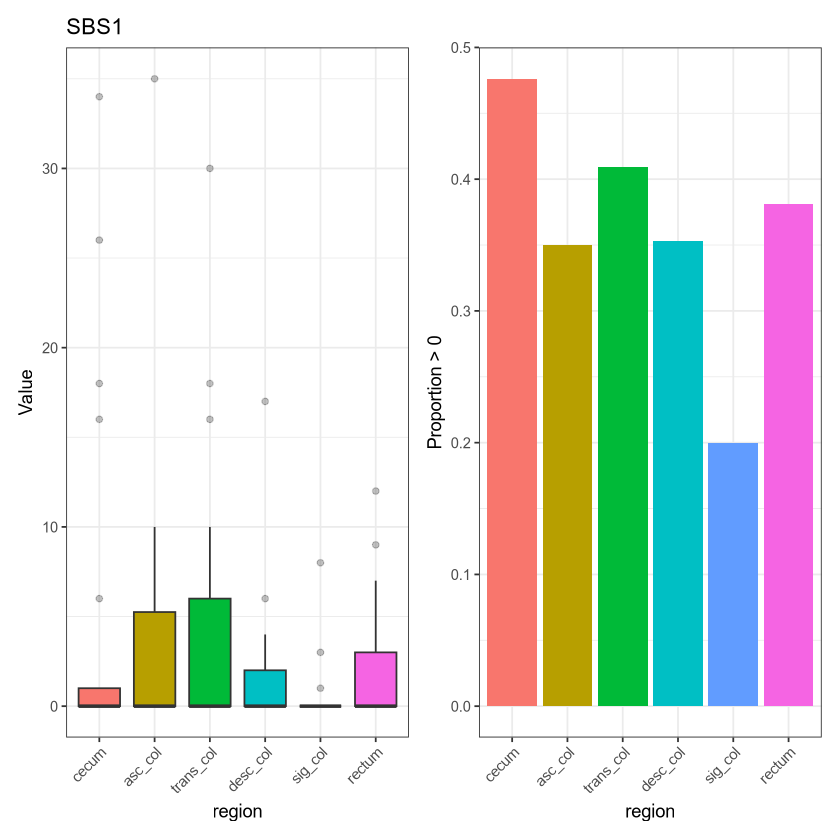

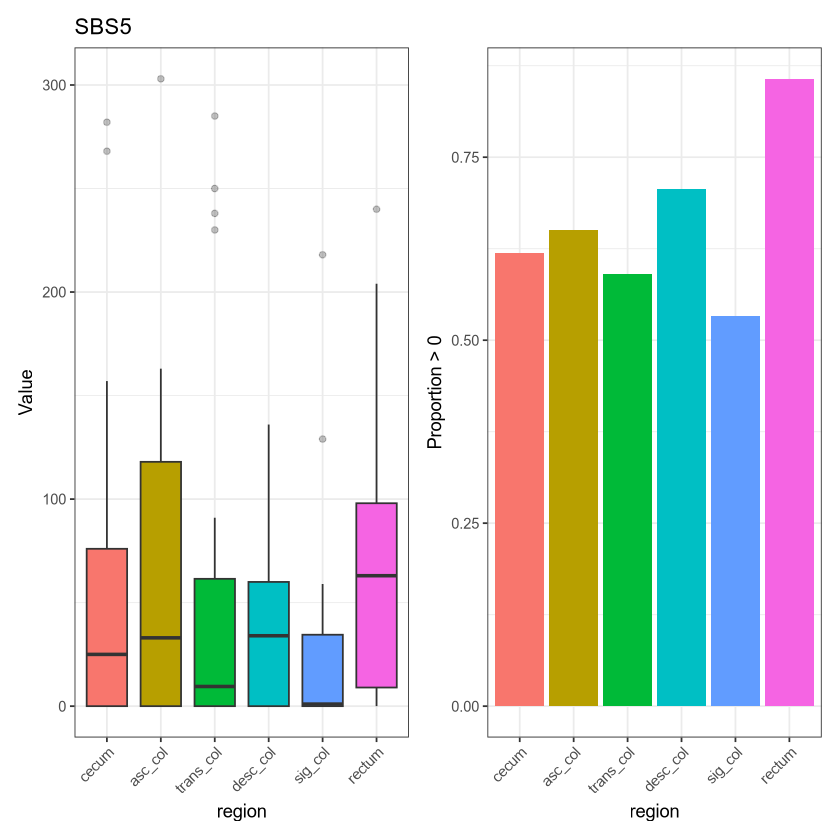

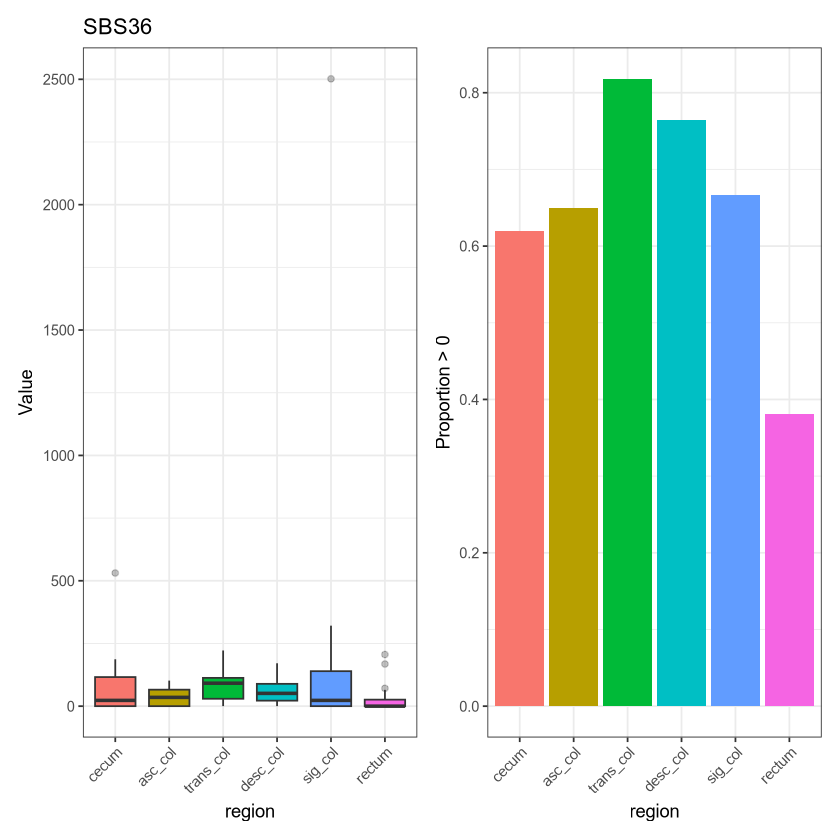

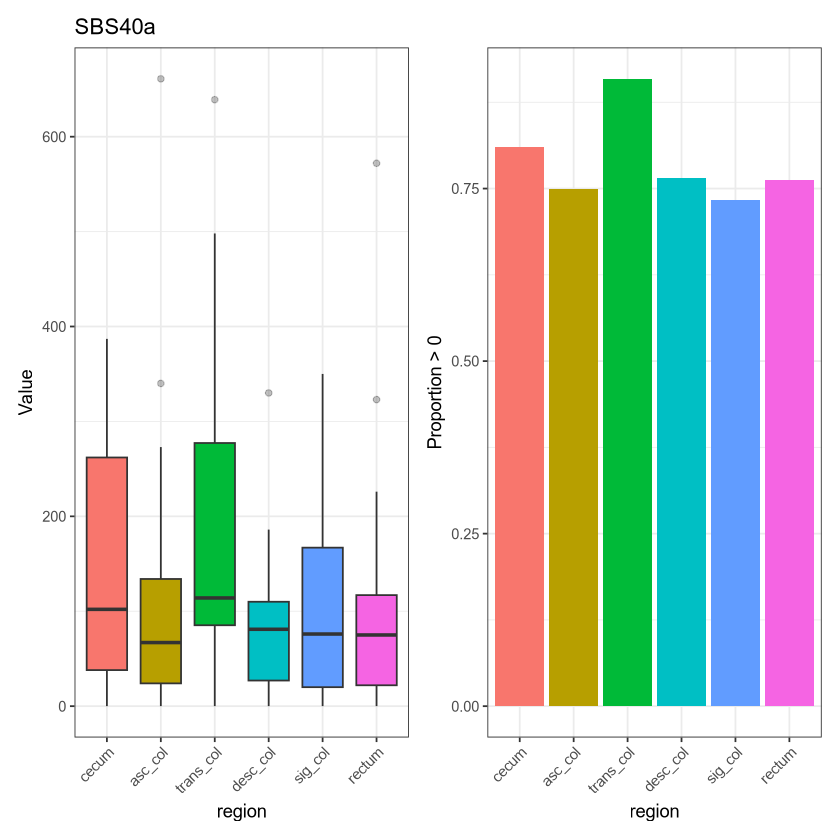

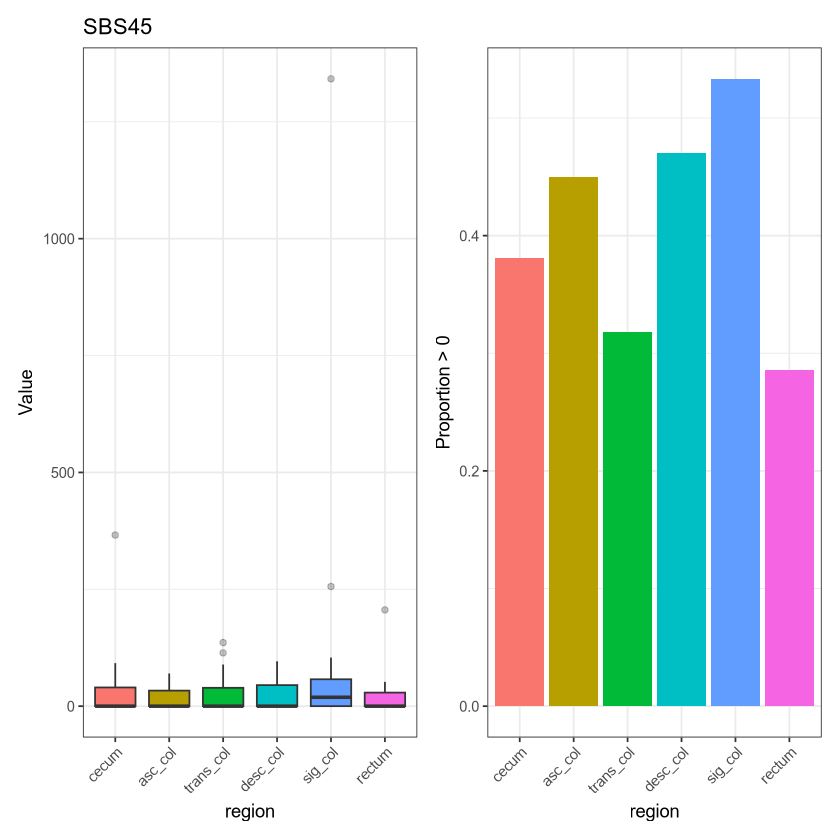

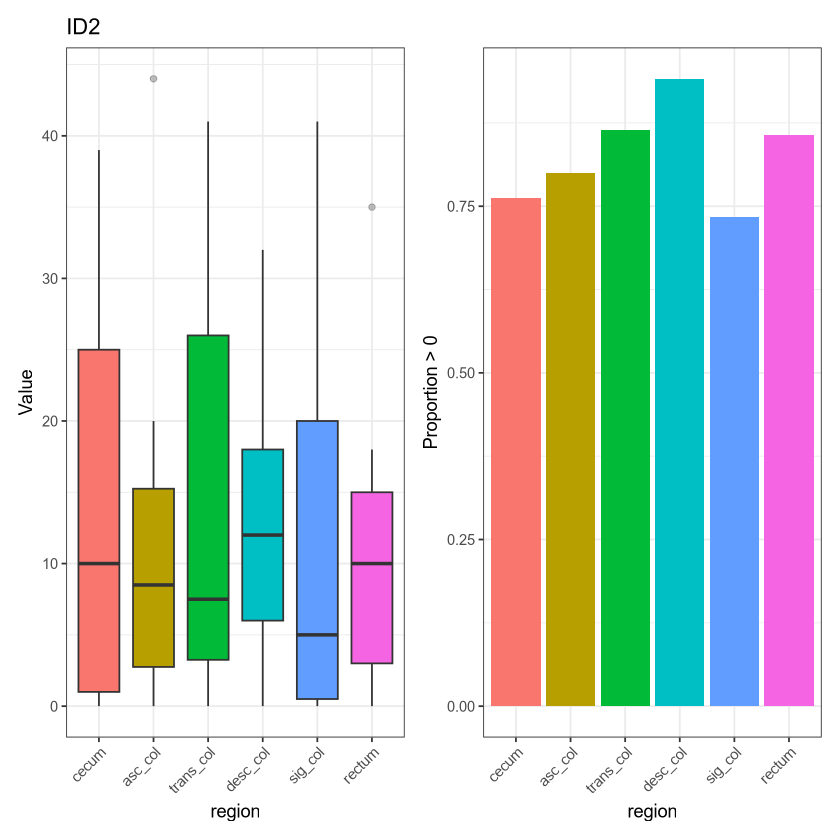

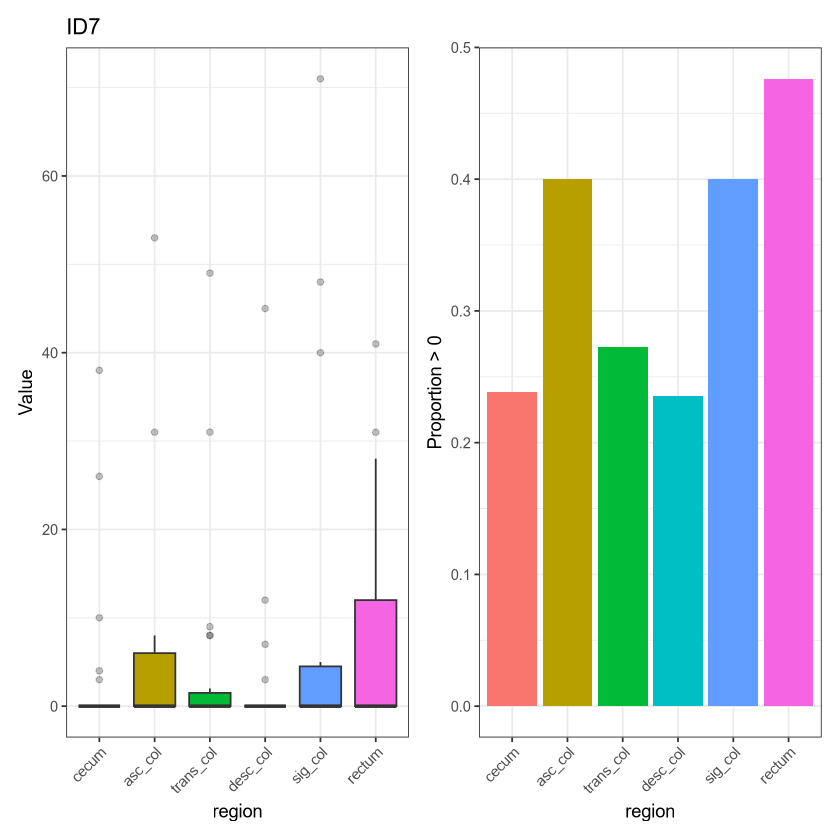

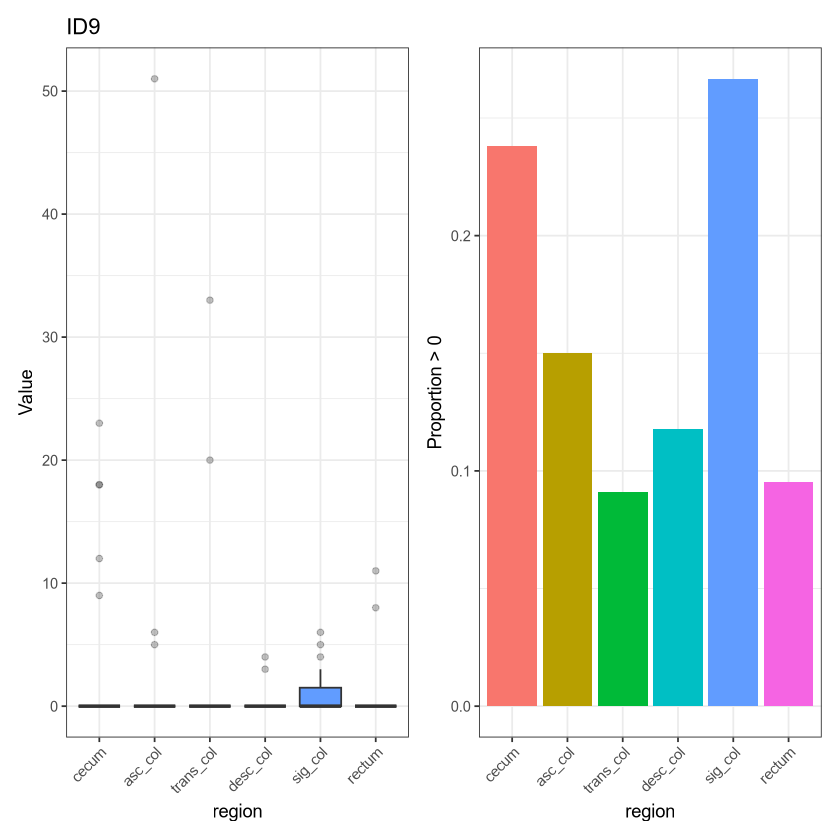

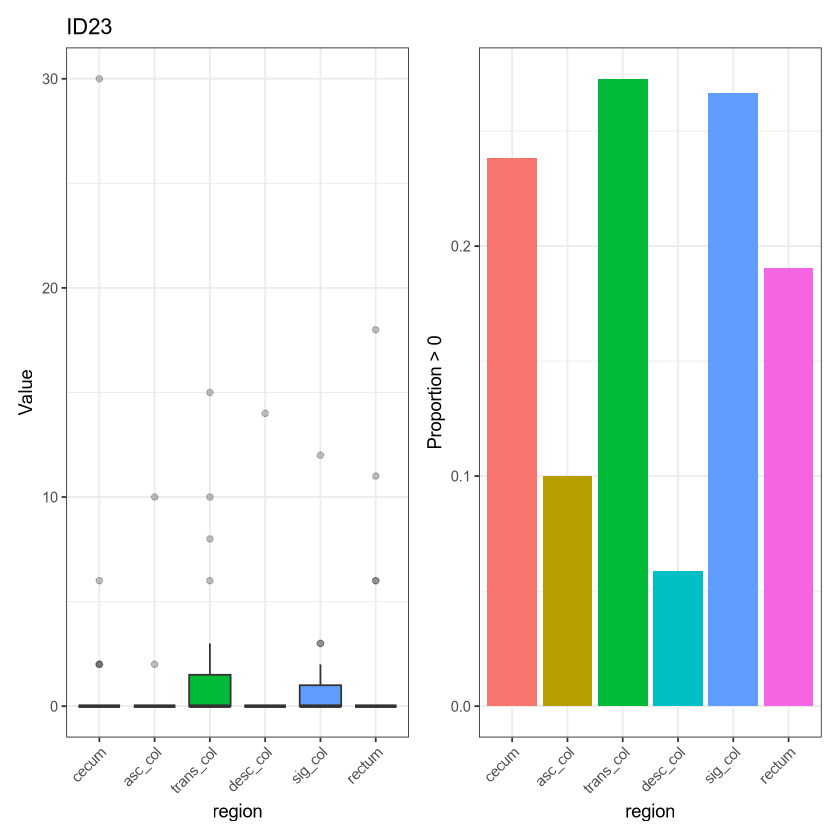

In [15]:
sig_long <- Hiatt %>%
  pivot_longer(cols = all_of(sig_cols),
               names_to = "signature",
               values_to = "value")

# 3. Split list: one data frame per signature
sig_list <- split(sig_long, sig_long$signature)

# 4. Function to generate one combined plot for a given signature
make_sig_plot <- function(df) {

  sig_name <- unique(df$signature)

  # barplot data
  prop_df <- df %>%
    mutate(has_signature = value > 0) %>%
    group_by(region) %>%
    summarize(prop = mean(has_signature), .groups = "drop")

  # boxplot
  p_box <- ggplot(df, aes(x = region, y = value, fill = region)) +
    geom_boxplot(outlier.alpha = 0.3) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylab("Value") +
    ggtitle(sig_name)

  # barplot
  p_bar <- ggplot(prop_df, aes(x = region, y = prop, fill = region)) +
    geom_col() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylab("Proportion > 0")

  # combine (boxplot | barplot)
  p_box | p_bar
}

# 5. Create the list of plots — one per signature
signature_plots <- lapply(sig_list, make_sig_plot)

# Now you can view one signature per page:
signature_plots[["SBS1"]]
signature_plots[["SBS5"]]
signature_plots[["SBS36"]]
signature_plots[["SBS40a"]]
signature_plots[["SBS45"]]
signature_plots[["ID2"]]
signature_plots[["ID7"]]
signature_plots[["ID9"]]
signature_plots[["ID23"]]

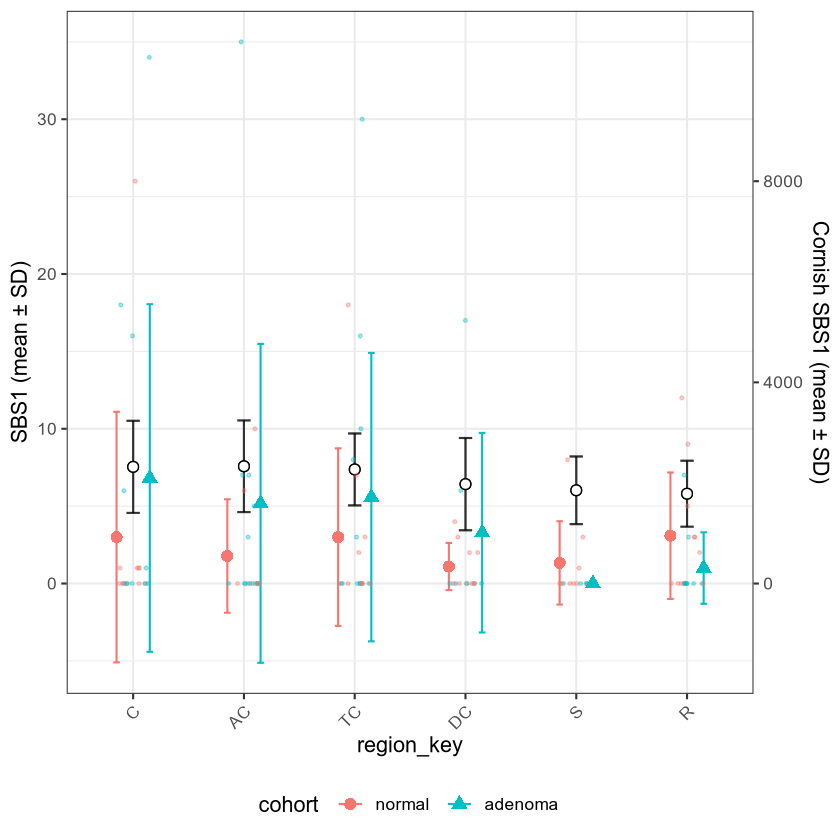

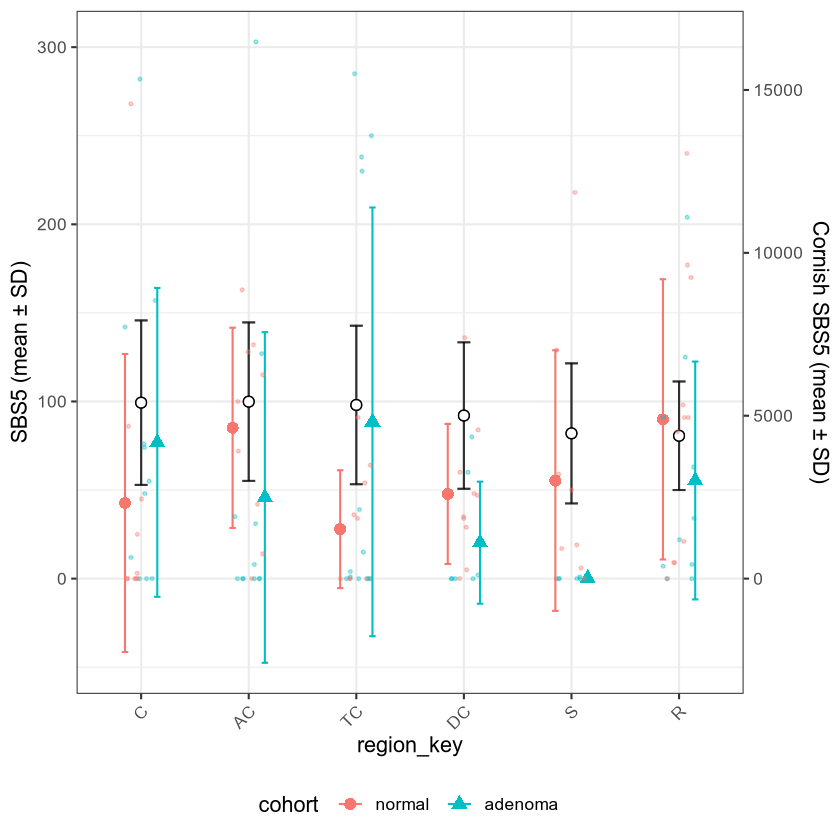

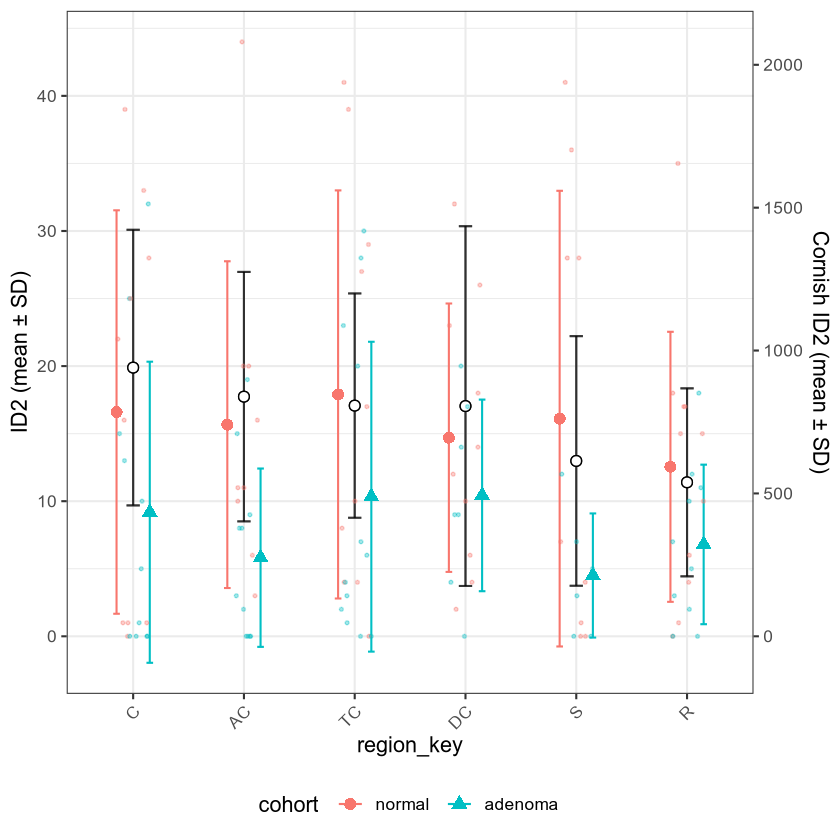

In [52]:
region_col <- "region"
cohort_col <- "cohort"

#df_raw <- Hiatt
df_raw <- Hiatt

# columns to plot: unique_IDs is used for INDELs per your message
plot_columns <- c("SBS1", "SBS5", "ID2")

normalise_cohort <- function(x) {
  x0 <- ifelse(is.na(x) | x == "", NA_character_, tolower(x) %>% str_trim())
  xc <- str_replace_all(x0, "[^a-z0-9]", "")
  dplyr::case_when(
    xc %in% c("normal","n","norm","ctrl","control","healthy","nonneoplastic") ~ "normal",
    xc %in% c("adenoma","adeno","adenomatous") ~ "adenoma",
    TRUE ~ ifelse(is.na(x0), "unknown", x0)
  )
}

# desired Cornish plotting order
cornish_order <- c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum")

df_base <- df_raw %>%
  mutate(
    region = as.character(.data[[region_col]]) %>% str_trim(),
    cohort_raw = if (cohort_col %in% names(df_raw)) as.character(.data[[cohort_col]]) else NA_character_,
    cohort = normalise_cohort(cohort_raw)
  ) %>%
  mutate(region = if_else(region %in% c("C","AC","HC","TC","DC","S","R"),
                          recode(region, "C"="cecum","AC"="asc_col","HC"="HF","TC"="trans_col","DC"="desc_col","S"="sig_col","R"="rectum"),
                          region))
present_regions <- intersect(unique(df_base$region), cornish_order)
if (length(present_regions) == 0) stop("No overlapping regions between your data and expected region keys.")
region_levels <- cornish_order[cornish_order %in% present_regions]
region_levels <- cornish_order[cornish_order %in% present_regions]
df_base <- df_base %>% filter(region %in% region_levels)
df_base <- df_base %>% mutate(cohort = factor(cohort, levels = c("normal","adenoma", "carcinoma")))

plot_signature <- function(value_col, cornish_df = NULL, show_jitter = TRUE) {
  if (!value_col %in% names(df_raw)) {
    message("Skipping ", value_col, " (not present in CSV).")
    return(invisible(NULL))
  }
  # numeric value vector aligned with df_base rows
  values <- as.numeric(df_raw[[value_col]][as.integer(rownames(df_base))])
  df <- df_base %>% mutate(value = values)

  summary_by_region <- df %>%
    group_by(region, cohort) %>%
    summarise(You_Mean = mean(value, na.rm = TRUE),
              You_SD   = sd(value, na.rm = TRUE),
              You_n    = sum(!is.na(value)), .groups = "drop")

  if (!is.null(cornish_df)) {
    req <- c("region_key","Cornish_Mean","Cornish_SD")
    if (!all(req %in% names(cornish_df))) stop("cornish_df must contain region_key, Cornish_Mean, Cornish_SD")
    cohorts_present <- sort(unique(summary_by_region$cohort))
    cornish_expanded <- expand.grid(region_key = region_levels, cohort = cohorts_present, stringsAsFactors = FALSE) %>%
      left_join(cornish_df, by = "region_key")
    merged <- cornish_expanded %>% left_join(summary_by_region, by = c("region_key"="region","cohort"="cohort"))
    max_your_mean <- suppressWarnings(max(merged$You_Mean, na.rm = TRUE))
    max_cornish <- suppressWarnings(max(merged$Cornish_Mean, na.rm = TRUE))
    scale_factor <- ifelse(is.na(max_your_mean) || max_your_mean <= 0, 1, {
      sf <- max_cornish / max_your_mean * 0.9
      if (is.na(sf) || sf < 1) 1 else sf
    })
    merged <- merged %>% mutate(Cornish_Mean_scaled = Cornish_Mean / scale_factor,
                                Cornish_SD_scaled = Cornish_SD / scale_factor)
  } else {
    merged <- summary_by_region %>% rename(region_key = region) %>% mutate(Cornish_Mean = NA, Cornish_SD = NA, Cornish_Mean_scaled = NA, Cornish_SD_scaled = NA)
    scale_factor <- 1
  }

  merged <- merged %>% mutate(region_key = factor(region_key, levels = region_levels))
  df <- df %>% mutate(region = factor(region, levels = region_levels))

  p <- ggplot() +
    { if (!is.null(cornish_df))
      list(
        geom_errorbar(data = merged, aes(x = region_key, ymin = Cornish_Mean_scaled - Cornish_SD_scaled, ymax = Cornish_Mean_scaled + Cornish_SD_scaled),
                      color = "black", width = 0.12, alpha = 0.55),
        geom_point(data = merged, aes(x = region_key, y = Cornish_Mean_scaled), color = "black", fill = "white", shape = 21, size = 2.6)
      ) } +
    geom_errorbar(data = merged %>% filter(!is.na(You_Mean)),
                  aes(x = region_key, ymin = You_Mean - You_SD, ymax = You_Mean + You_SD, color = cohort),
                  position = position_dodge(width = 0.6), width = 0.12) +
    geom_point(data = merged %>% filter(!is.na(You_Mean)),
               aes(x = region_key, y = You_Mean, color = cohort, shape = cohort),
               position = position_dodge(width = 0.6), size = 3)

  if (show_jitter) {
    p <- p + geom_jitter(data = df, aes(x = region, y = value, color = cohort), width = 0.15, height = 0, alpha = 0.35, size = 0.7, show.legend = FALSE)
  }

  p <- p +
    scale_x_discrete(labels = c("cecum"="C","asc_col"="AC","HF"="HC","trans_col"="TC","SF"="SF","desc_col"="DC","sig_col"="S","RS"="RS","rectum"="R")) +
    scale_y_continuous(name = paste0(value_col, " (mean ± SD)"),
                       sec.axis = sec_axis(~ . * scale_factor, name = paste0("Cornish ", value_col, " (mean ± SD)"))) +
    labs(color = "cohort", shape = "cohort") +
    theme_bw(base_size = 13) + theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "bottom")

  print(p)
  invisible(list(plot = p, merged = merged, df = df))
}

# ---- RUN plotting loop: pass the correct Cornish df for each column ----
for (col in plot_columns) {
  if (col == "unique_SNVs") {
    plot_signature(col, cornish_df = Cornish_SNVs, show_jitter = TRUE)
  } else if (col == "total_indels") {
    plot_signature(col, cornish_df = Cornish_INDELs, show_jitter = TRUE)
  } else if (col == "SBS18") {
    plot_signature(col, cornish_df = Cornish_SBS18, show_jitter = TRUE)
  } else if (col == "SBS1") {
    plot_signature(col, cornish_df = Cornish_SBS1, show_jitter = TRUE)
  } else if (col == "SBS5") {
    plot_signature(col, cornish_df = Cornish_SBS5, show_jitter = TRUE)
  } else if (col == "ID18") {
    plot_signature(col, cornish_df = Cornish_ID18, show_jitter = TRUE)
  } else if (col == "ID1") {
    plot_signature(col, cornish_df = Cornish_ID1, show_jitter = TRUE)
  } else if (col == "ID2") {
    plot_signature(col, cornish_df = Cornish_ID2, show_jitter = TRUE)
  } else {
    plot_signature(col, cornish_df = NULL, show_jitter = TRUE)
  }
}


Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_point()`).”


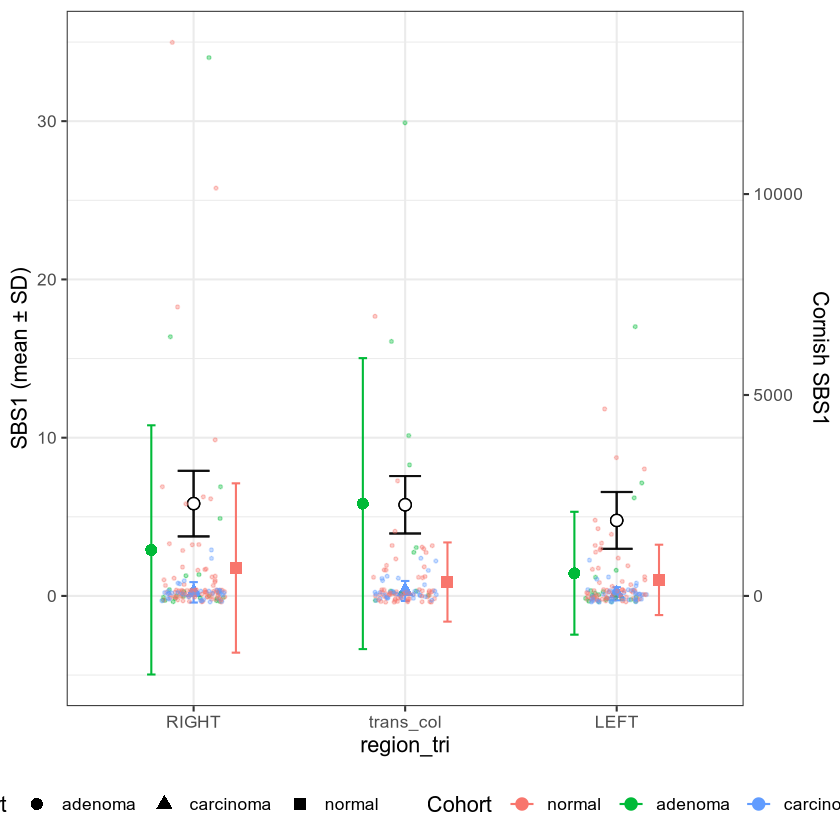

Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_point()`).”


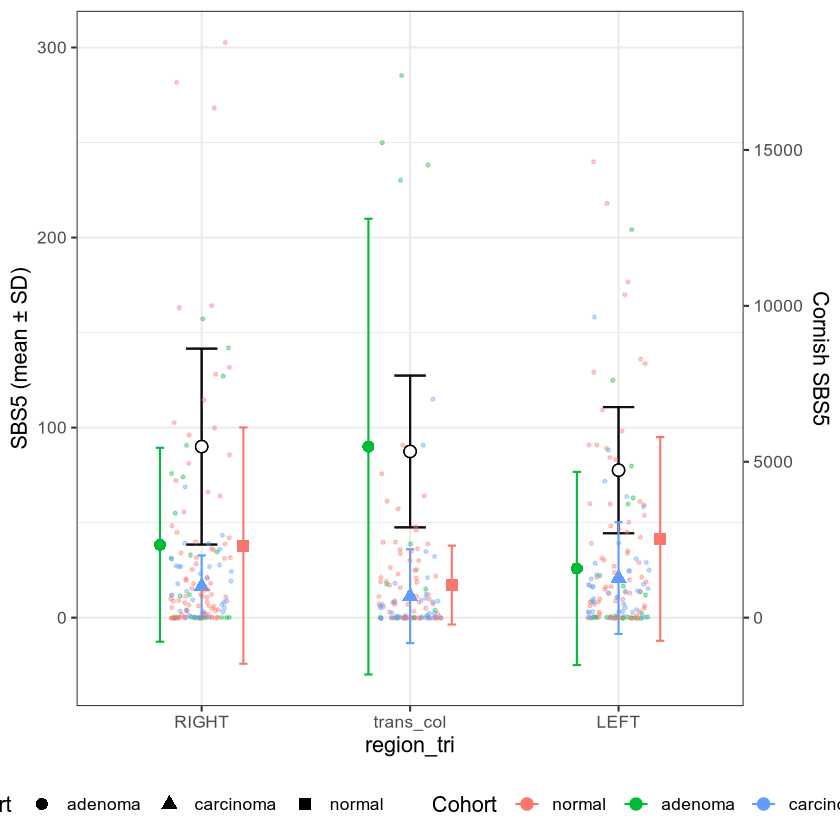

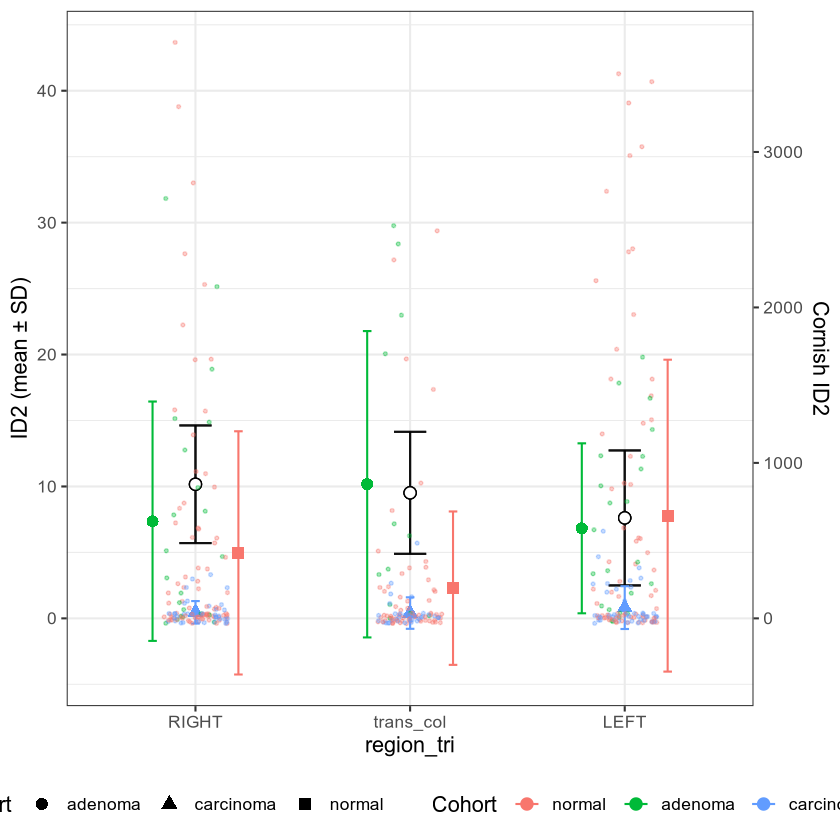

In [53]:
df_raw <- combined_df
# ---- collapse helper ----
collapse_to_tri <- function(x) {
  case_when(
    x %in% c("right", "cecum", "asc_col", "hf") ~ "RIGHT",
    x == "trans_col" ~ "trans_col",
    TRUE ~ "LEFT"
  )
}

df_base <- df_raw %>%
  mutate(
    region = as.character(.data[[region_col]]) |> str_trim() |> str_to_lower(),
    cohort_raw = if (cohort_col %in% names(df_raw)) as.character(.data[[cohort_col]]) else NA_character_,
    cohort = normalise_cohort(cohort_raw)
  ) %>%
  mutate(
    region = recode(
      region,
      "c"="cecum","ac"="asc_col","hc"="hf","tc"="trans_col",
      "dc"="desc_col","s"="sig_col","r"="rectum",
      .default = region
    )
  ) %>%
  mutate(
    region_tri = collapse_to_tri(region),
    region_tri = factor(region_tri, levels = c("RIGHT","trans_col","LEFT")),
    cohort = factor(cohort, levels = c("normal","adenoma","carcinoma"))
  )

# 🔒 sanity check
stopifnot(any(df_base$cohort == "carcinoma"))
stopifnot(!any(is.na(df_base$region_tri)))

plot_signature <- function(value_col, cornish_df = NULL, show_jitter = TRUE) {

  if (!value_col %in% names(df_raw)) return(invisible(NULL))

  df <- df_base %>%
    mutate(value = as.numeric(df_raw[[value_col]][as.integer(rownames(df_base))]))

  # ---- YOUR DATA ----
  summary_by_region <- df %>%
    group_by(region_tri, cohort) %>%
    summarise(
      You_Mean = mean(value, na.rm = TRUE),
      You_SD   = sd(value, na.rm = TRUE),
      .groups = "drop"
    )

  # ---- CORNISH ----
  if (!is.null(cornish_df)) {
    cornish_tri <- cornish_df %>%
      mutate(region_tri = collapse_to_tri(tolower(region_key))) %>%
      group_by(region_tri) %>%
      summarise(
        Cornish_Mean = mean(Cornish_Mean),
        Cornish_SD   = mean(Cornish_SD),
        .groups = "drop"
      )

    merged <- tidyr::expand_grid(
      region_tri = levels(df$region_tri),
      cohort = levels(df$cohort)
    ) %>%
      left_join(summary_by_region, by = c("region_tri","cohort")) %>%
      left_join(cornish_tri, by = "region_tri")

    scale_factor <- max(merged$Cornish_Mean, na.rm = TRUE) /
      max(merged$You_Mean, na.rm = TRUE)

    merged <- merged %>%
      mutate(
        Cornish_Mean_scaled = Cornish_Mean / scale_factor,
        Cornish_SD_scaled   = Cornish_SD / scale_factor
      )
  } else {
    merged <- summary_by_region
    scale_factor <- 1
  }

  # ---- PLOT ----
  p <- ggplot() +

    # Cornish reference
    { if (!is.null(cornish_df))
      list(
        geom_errorbar(
          data = merged,
          aes(x = region_tri,
              ymin = Cornish_Mean_scaled - Cornish_SD_scaled,
              ymax = Cornish_Mean_scaled + Cornish_SD_scaled),
          width = 0.15, color = "black", alpha = 0.6
        ),
        geom_point(
          data = merged,
          aes(x = region_tri, y = Cornish_Mean_scaled),
          shape = 21, fill = "white", color = "black", size = 3
        )
      )
    } +

    # Cohorts
    geom_errorbar(
      data = merged,
      aes(x = region_tri,
          ymin = You_Mean - You_SD,
          ymax = You_Mean + You_SD,
          color = cohort),
      position = position_dodge(0.6), width = 0.12
    ) +
    geom_point(
      data = merged,
      aes(x = region_tri, y = You_Mean,
          color = cohort, shape = cohort),
      position = position_dodge(0.6), size = 3
    )

  if (show_jitter) {
    p <- p +
      geom_jitter(
        data = df,
        aes(x = region_tri, y = value, color = cohort),
        width = 0.15, alpha = 0.35, size = 0.7,
        show.legend = FALSE
      )
  }

  p <- p +
    scale_y_continuous(
      name = paste0(value_col, " (mean ± SD)"),
      sec.axis = sec_axis(~ . * scale_factor,
                          name = paste0("Cornish ", value_col))
    ) +
    labs(color = "Cohort", shape = "Cohort") +
    theme_bw(base_size = 13) +
    theme(legend.position = "bottom")

  print(p)
}

# ---- RUN plotting loop: pass the correct Cornish df for each column ----
for (col in plot_columns) {
  if (col == "unique_SNVs") {
    plot_signature(col, cornish_df = Cornish_SNVs, show_jitter = TRUE)
  } else if (col == "total_indels") {
    plot_signature(col, cornish_df = Cornish_INDELs, show_jitter = TRUE)
  } else if (col == "SBS18") {
    plot_signature(col, cornish_df = Cornish_SBS18, show_jitter = TRUE)
  } else if (col == "SBS1") {
    plot_signature(col, cornish_df = Cornish_SBS1, show_jitter = TRUE)
  } else if (col == "SBS5") {
    plot_signature(col, cornish_df = Cornish_SBS5, show_jitter = TRUE)
  } else if (col == "ID18") {
    plot_signature(col, cornish_df = Cornish_ID18, show_jitter = TRUE)
  } else if (col == "ID1") {
    plot_signature(col, cornish_df = Cornish_ID1, show_jitter = TRUE)
  } else if (col == "ID2") {
    plot_signature(col, cornish_df = Cornish_ID2, show_jitter = TRUE)
  } else {
    plot_signature(col, cornish_df = NULL, show_jitter = TRUE)
  }
}

In [54]:
df_long <- df_base %>%
  pivot_longer(
    cols = all_of(plot_columns),
    names_to = "signature",
    values_to = "value"
  )


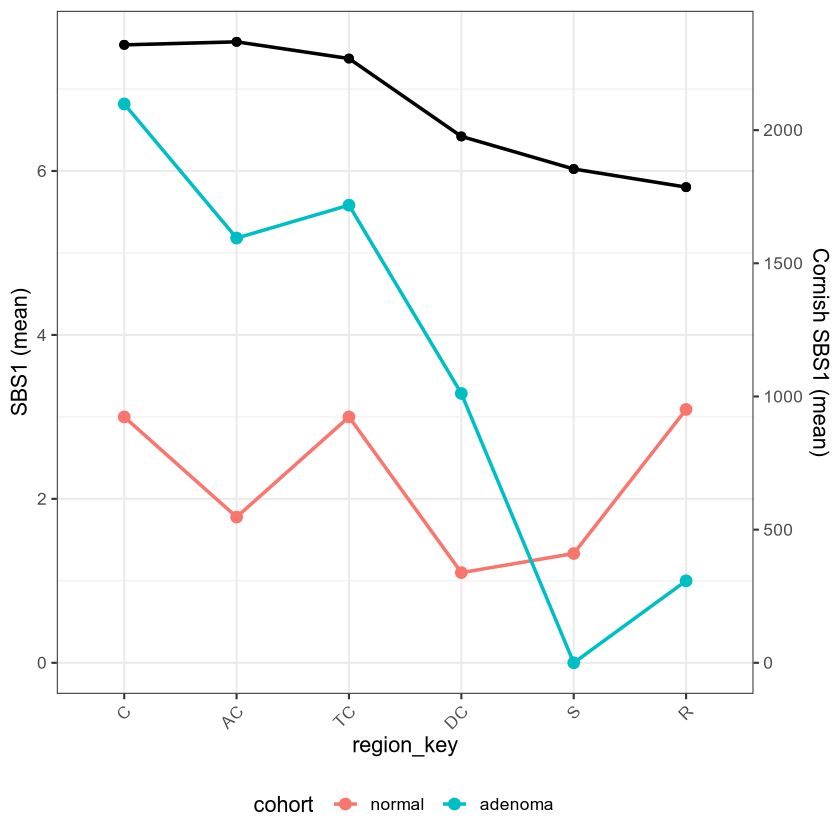

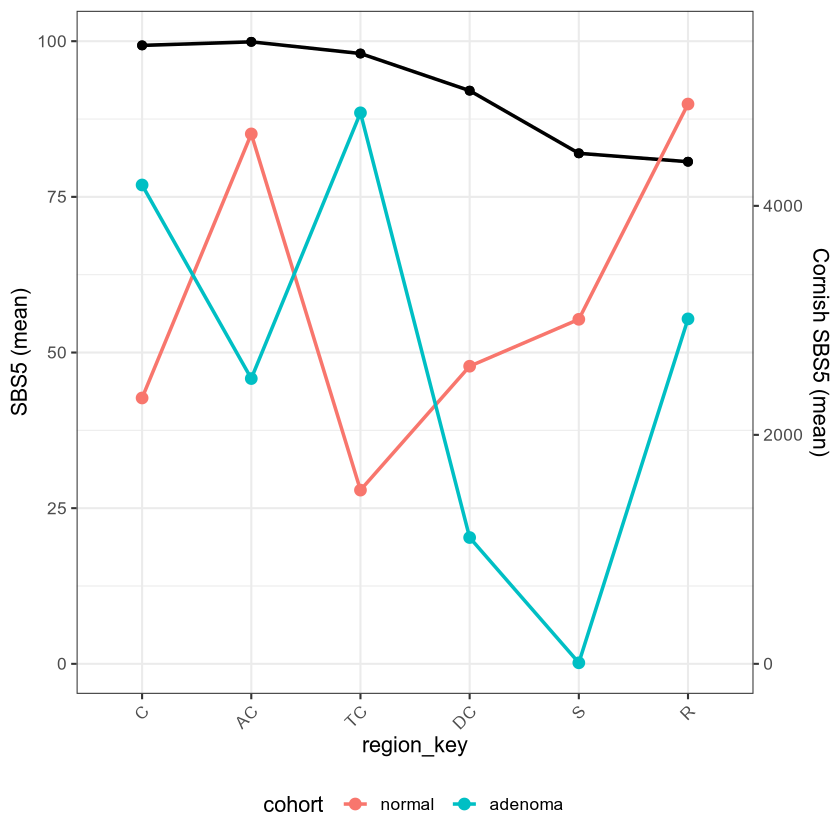

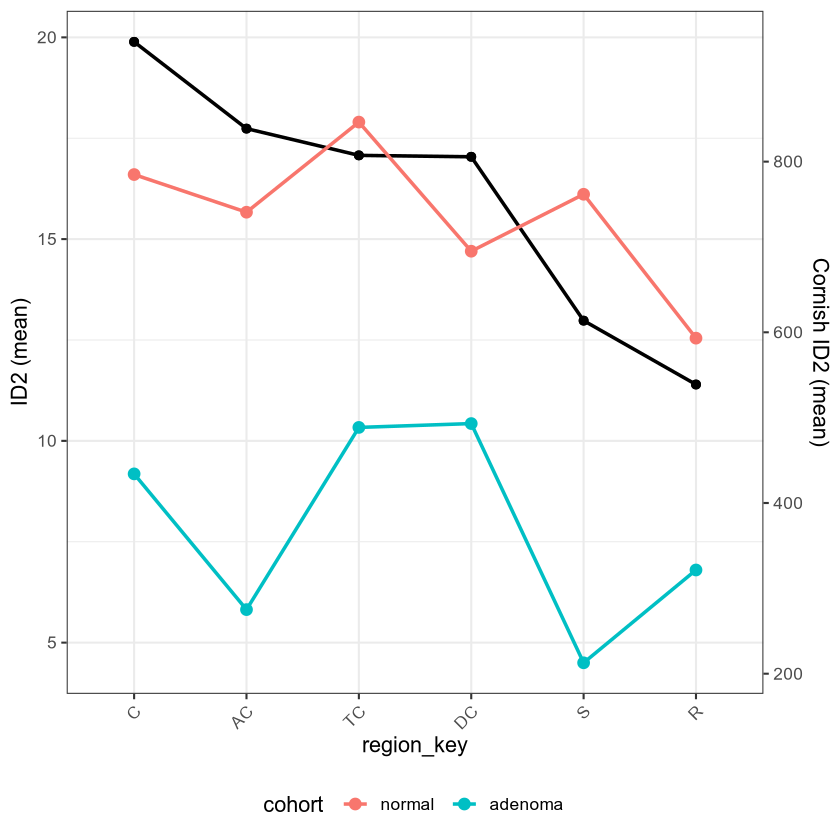

In [60]:
region_col <- "region"
cohort_col <- "cohort"

df_raw <- Hiatt

# ------------------------------
# cohort normalisation
# ------------------------------
normalise_cohort <- function(x) {
  x0 <- ifelse(is.na(x) | x == "", NA_character_, tolower(x) %>% str_trim())
  xc <- str_replace_all(x0, "[^a-z0-9]", "")
  dplyr::case_when(
    xc %in% c("normal","n","norm","ctrl","control","healthy","nonneoplastic") ~ "normal",
    xc %in% c("adenoma","adeno","adenomatous") ~ "adenoma",
    xc %in% c("carcinoma","crc","cancer","tumour","tumor") ~ "carcinoma",
    TRUE ~ ifelse(is.na(x0), "unknown", x0)
  )
}

# ------------------------------
# Cornish bowel order
# ------------------------------
cornish_order <- c(
  "cecum",
  "asc_col",
  "HF",
  "trans_col",
  "SF",
  "desc_col",
  "sig_col",
  "RS",
  "rectum"
)

# ------------------------------
# base dataframe
# ------------------------------
df_base <- df_raw %>%
  mutate(
    region = as.character(.data[[region_col]]) %>% str_trim(),
    cohort_raw = if (cohort_col %in% names(df_raw)) as.character(.data[[cohort_col]]) else NA_character_,
    cohort = normalise_cohort(cohort_raw)
  ) %>%
  mutate(
    region = if_else(
      region %in% c("C","AC","HC","TC","DC","S","R"),
      recode(
        region,
        "C"  = "cecum",
        "AC" = "asc_col",
        "HC" = "HF",
        "TC" = "trans_col",
        "DC" = "desc_col",
        "S"  = "sig_col",
        "R"  = "rectum"
      ),
      region
    )
  )

present_regions <- intersect(unique(df_base$region), cornish_order)
if (length(present_regions) == 0)
  stop("No overlapping regions between your data and expected region keys.")

region_levels <- cornish_order[cornish_order %in% present_regions]

df_base <- df_base %>%
  filter(region %in% region_levels) %>%
  mutate(
    region = factor(region, levels = region_levels),
    cohort = factor(cohort, levels = c("normal","adenoma","carcinoma"))
  )

# ============================================================
# PLOTTING FUNCTION (LINE-ONLY VERSION)
# ============================================================
plot_signature <- function(value_col, cornish_df = NULL) {

  if (!value_col %in% names(df_raw)) {
    message("Skipping ", value_col, " (not present).")
    return(invisible(NULL))
  }

  values <- as.numeric(df_raw[[value_col]][as.integer(rownames(df_base))])

  df <- df_base %>%
    mutate(value = values)

  summary_by_region <- df %>%
    group_by(region, cohort) %>%
    summarise(
      You_Mean = mean(value, na.rm = TRUE),
      .groups = "drop"
    )

  # ---- Cornish handling + scaling ----
  if (!is.null(cornish_df)) {

    req <- c("region_key","Cornish_Mean","Cornish_SD")
    if (!all(req %in% names(cornish_df)))
      stop("cornish_df must contain region_key, Cornish_Mean, Cornish_SD")

    cohorts_present <- sort(unique(summary_by_region$cohort))

    cornish_expanded <- expand.grid(
      region_key = region_levels,
      cohort = cohorts_present,
      stringsAsFactors = FALSE
    ) %>%
      left_join(cornish_df, by = "region_key")

    merged <- cornish_expanded %>%
      left_join(summary_by_region, by = c("region_key" = "region", "cohort"))

    max_you <- suppressWarnings(max(merged$You_Mean, na.rm = TRUE))
    max_cornish <- suppressWarnings(max(merged$Cornish_Mean, na.rm = TRUE))

    scale_factor <- ifelse(
      is.na(max_you) || max_you <= 0,
      1,
      {
        sf <- max_cornish / max_you * 0.9
        if (is.na(sf) || sf < 1) 1 else sf
      }
    )

    merged <- merged %>%
      mutate(
        Cornish_Mean_scaled = Cornish_Mean / scale_factor
      )

  } else {

    merged <- summary_by_region %>%
      rename(region_key = region) %>%
      mutate(
        Cornish_Mean = NA,
        Cornish_Mean_scaled = NA
      )

    scale_factor <- 1
  }

  merged <- merged %>%
    mutate(region_key = factor(region_key, levels = region_levels))

  # ------------------------------
  # PLOT
  # ------------------------------
  p <- ggplot() +

    # Cornish reference line
    { if (!is.null(cornish_df))
      list(
        geom_line(
          data = merged,
          aes(x = region_key, y = Cornish_Mean_scaled, group = 1),
          color = "black",
          linewidth = 1
        ),
        geom_point(
          data = merged,
          aes(x = region_key, y = Cornish_Mean_scaled),
          color = "black",
          size = 2
        )
      )
    } +

    # Your cohort lines
    geom_line(
      data = merged %>% filter(!is.na(You_Mean)),
      aes(
        x = region_key,
        y = You_Mean,
        color = cohort,
        group = cohort
      ),
      linewidth = 1
    ) +

    geom_point(
      data = merged %>% filter(!is.na(You_Mean)),
      aes(
        x = region_key,
        y = You_Mean,
        color = cohort
      ),
      size = 2.8
    ) +

    scale_x_discrete(
      labels = c(
        "cecum"="C","asc_col"="AC","HF"="HC",
        "trans_col"="TC","SF"="SF","desc_col"="DC",
        "sig_col"="S","RS"="RS","rectum"="R"
      )
    ) +

    scale_y_continuous(
      name = paste0(value_col, " (mean)"),
      sec.axis = sec_axis(
        ~ . * scale_factor,
        name = paste0("Cornish ", value_col, " (mean)")
      )
    ) +

    labs(color = "cohort") +
    theme_bw(base_size = 13) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    )

  print(p)
  invisible(list(plot = p, merged = merged))
}

# ============================================================
# RUN LOOP
# ============================================================
for (col in plot_columns) {
  if (col == "SBS1") {
    plot_signature(col, cornish_df = Cornish_SBS1)
  } else if (col == "SBS5") {
    plot_signature(col, cornish_df = Cornish_SBS5)
  } else if (col == "ID2") {
    plot_signature(col, cornish_df = Cornish_ID2)
  } else {
    plot_signature(col, cornish_df = NULL)
}
}


Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


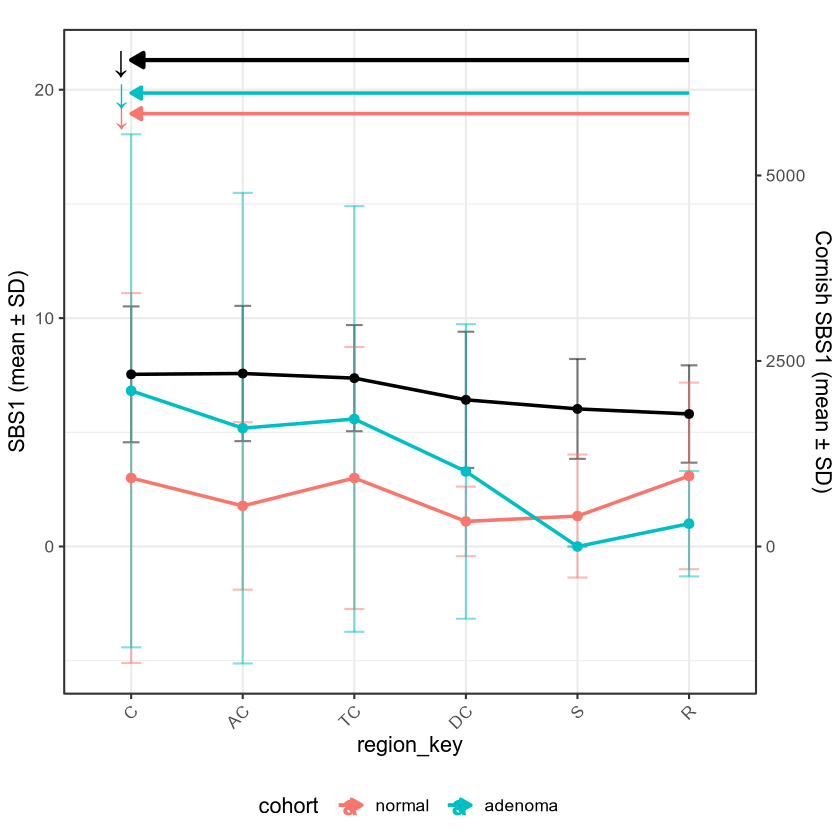

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


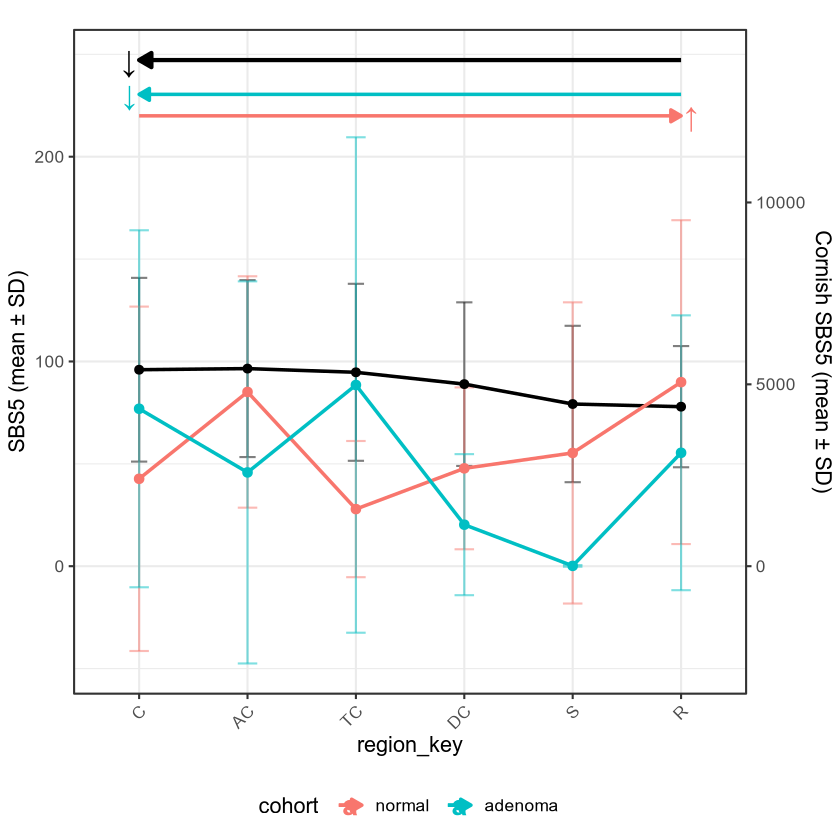

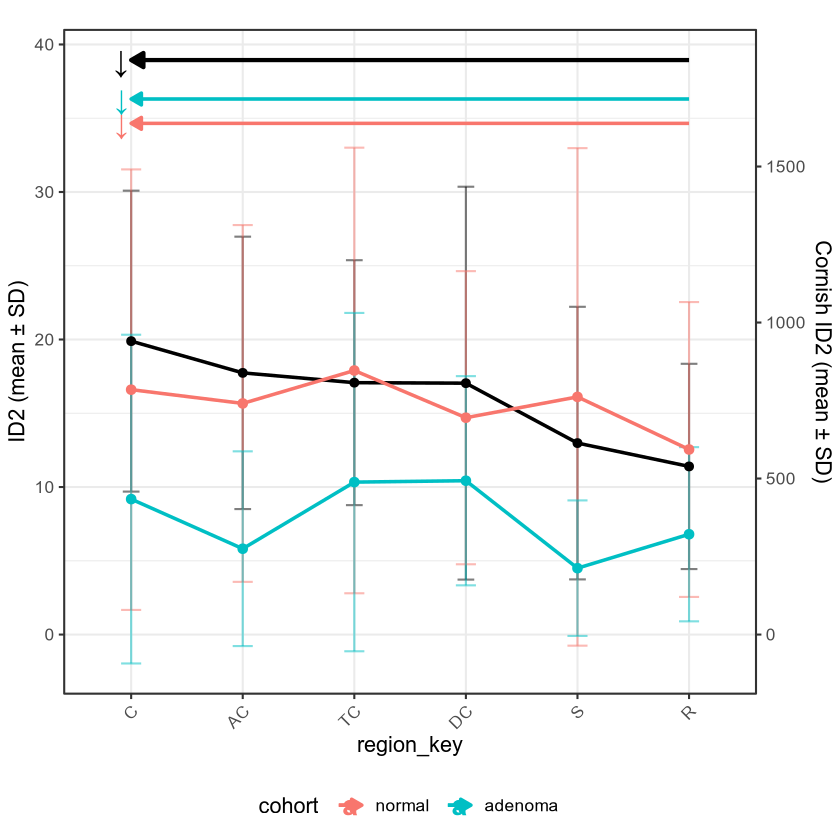

In [57]:
df_long <- df_base %>%
  pivot_longer(
    cols = all_of(plot_columns),
    names_to = "signature",
    values_to = "value"
  )

plot_faceted_signature_page <- function(signature_name, cornish_df) {

  df_sig <- df_long %>%
    filter(signature == signature_name)

  summary_sig <- df_sig %>%
    group_by(region, cohort) %>%
    summarise(
      mean = mean(value, na.rm = TRUE),
      sd   = sd(value, na.rm = TRUE),
      .groups = "drop"
    )

  # ----------------------------------
  # Direction arrows: cohorts
  # ----------------------------------
  direction_df <- summary_sig %>%
    mutate(region_num = as.numeric(region)) %>%
    group_by(cohort) %>%
    summarise(
      slope = coef(lm(mean ~ region_num))[2],
      .groups = "drop"
    ) %>%
    mutate(direction = ifelse(slope > 0, "up", "down"))

  y_base <- max(summary_sig$mean + summary_sig$sd, na.rm = TRUE)

  arrow_df <- direction_df %>%
    mutate(
      x_from = ifelse(direction == "up",
                      region_levels[1],
                      region_levels[length(region_levels)]),
      x_to   = ifelse(direction == "up",
                      region_levels[length(region_levels)],
                      region_levels[1]),
      y = y_base * case_when(
        cohort == "normal"  ~ 1.05,
        cohort == "adenoma" ~ 1.10,
        TRUE                ~ 1.05
      )
    )

  # ----------------------------------
  # Cornish scaling
  # ----------------------------------
  max_you     <- max(summary_sig$mean, na.rm = TRUE)
  max_cornish <- max(cornish_df$Cornish_Mean, na.rm = TRUE)

  scale_factor <- ifelse(
    is.na(max_you) | max_you <= 0,
    1,
    pmax(1, max_cornish / max_you * 0.9)
  )

  cornish_df <- cornish_df %>%
    mutate(
      Cornish_Mean_scaled = Cornish_Mean / scale_factor,
      Cornish_SD_scaled   = Cornish_SD   / scale_factor,
      region_key = factor(region_key, levels = region_levels)
    )

  # ----------------------------------
  # Cornish direction arrow
  # ----------------------------------
  cornish_arrow <- cornish_df %>%
    mutate(region_num = as.numeric(region_key)) %>%
    summarise(
      slope = coef(lm(Cornish_Mean ~ region_num))[2]
    ) %>%
    mutate(
      direction = ifelse(slope > 0, "up", "down"),
      x_from = ifelse(direction == "up",
                      region_levels[1],
                      region_levels[length(region_levels)]),
      x_to   = ifelse(direction == "up",
                      region_levels[length(region_levels)],
                      region_levels[1]),
      y = y_base * 1.18
    )

  # ----------------------------------
  # Plot
  # ----------------------------------
  p <- ggplot(summary_sig, aes(x = region, y = mean, color = cohort)) +

     ## ---- Cornish error bars ----
    geom_errorbar(
      data = cornish_df,
      aes(
        x = region_key,
        ymin = Cornish_Mean_scaled - Cornish_SD_scaled,
        ymax = Cornish_Mean_scaled + Cornish_SD_scaled
      ),
      inherit.aes = FALSE,
      width = 0.15,
      linewidth = 0.6,
      alpha = 0.5,
      color = "black"
    ) +

    ## ---- Cohort error bars ----
    geom_errorbar(
      aes(
        ymin = mean - sd,
        ymax = mean + sd,
        group = cohort
      ),
      width = 0.18,
      linewidth = 0.6,
      alpha = 0.5
    ) +


    ## ---- Cornish mean line + points ----
    geom_line(
      data = cornish_df,
      aes(x = region_key, y = Cornish_Mean_scaled, group = 1),
      inherit.aes = FALSE,
      color = "black",
      linewidth = 1
    ) +

    geom_point(
      data = cornish_df,
      aes(x = region_key, y = Cornish_Mean_scaled),
      inherit.aes = FALSE,
      color = "black",
      size = 2
    ) +



    ## ---- Cohort trend lines + points ----
    geom_line(aes(group = cohort), linewidth = 1) +
    geom_point(size = 2.2) +



    ## ---- Cohort arrows ----
    geom_segment(
      data = arrow_df,
      aes(
        x = x_from,
        xend = x_to,
        y = y,
        yend = y,
        color = cohort
      ),
      arrow = arrow(length = unit(0.25, "cm"), type = "closed"),
      linewidth = 1,
      inherit.aes = FALSE
    ) +

    geom_text(
      data = arrow_df,
      aes(
        x = x_to,
        y = y,
        label = ifelse(direction == "up", "↑", "↓"),
        color = cohort
      ),
      hjust = ifelse(arrow_df$direction == "up", -0.2, 1.2),
      size = 6,
      fontface = "bold",
      inherit.aes = FALSE
    ) +

    ## ---- Cornish arrow ----
    geom_segment(
      data = cornish_arrow,
      aes(
        x = x_from,
        xend = x_to,
        y = y,
        yend = y
      ),
      arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
      linewidth = 1.2,
      color = "black",
      inherit.aes = FALSE
    ) +

    geom_text(
      data = cornish_arrow,
      aes(
        x = x_to,
        y = y,
        label = ifelse(direction == "up", "↑", "↓")
      ),
      hjust = ifelse(cornish_arrow$direction == "up", -0.2, 1.2),
      size = 6.5,
      fontface = "bold",
      color = "black",
      inherit.aes = FALSE
    ) +

    scale_x_discrete(
      limits = region_levels,
      labels = c(
        "cecum"="C","asc_col"="AC","HF"="HC",
        "trans_col"="TC","SF"="SF","desc_col"="DC",
        "sig_col"="S","RS"="RS","rectum"="R"
      )
    ) +

    scale_y_continuous(
      name = paste0(signature_name, " (mean ± SD)"),
      sec.axis = sec_axis(
        ~ . * scale_factor,
        name = paste0("Cornish ", signature_name, " (mean ± SD)")
      )
    ) +

    coord_cartesian(clip = "off") +
    theme_bw(base_size = 13) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom",
      plot.margin = margin(t = 18, r = 5, b = 5, l = 5)
    )

  print(p)
}

plot_faceted_signature_page("SBS1",  Cornish_SBS1)
plot_faceted_signature_page("SBS5",  Cornish_SBS5)
plot_faceted_signature_page("ID2",  Cornish_ID2)

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


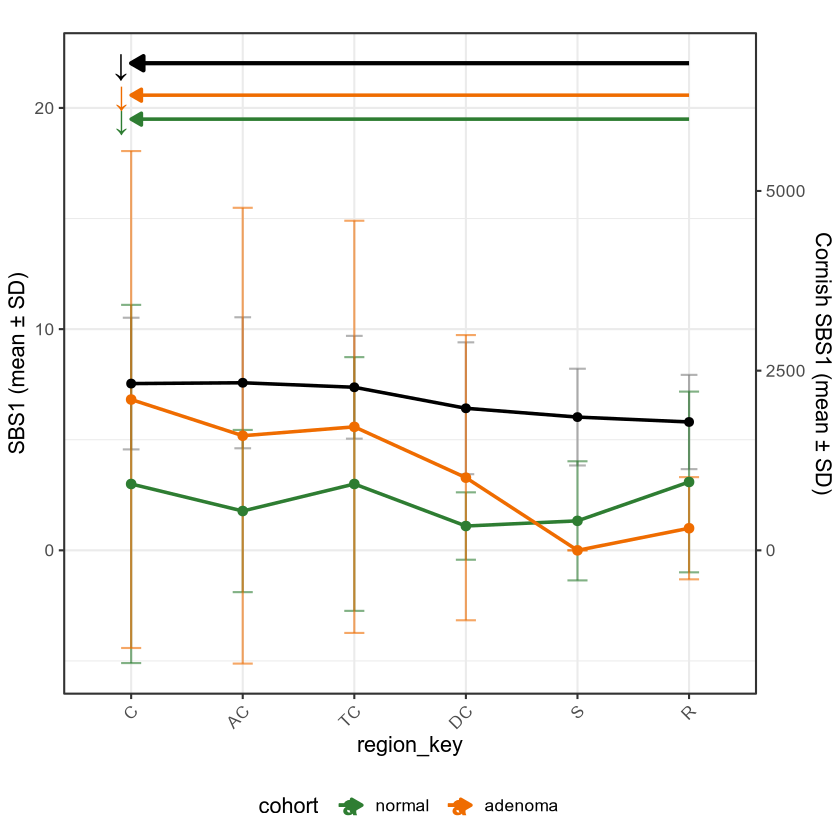

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


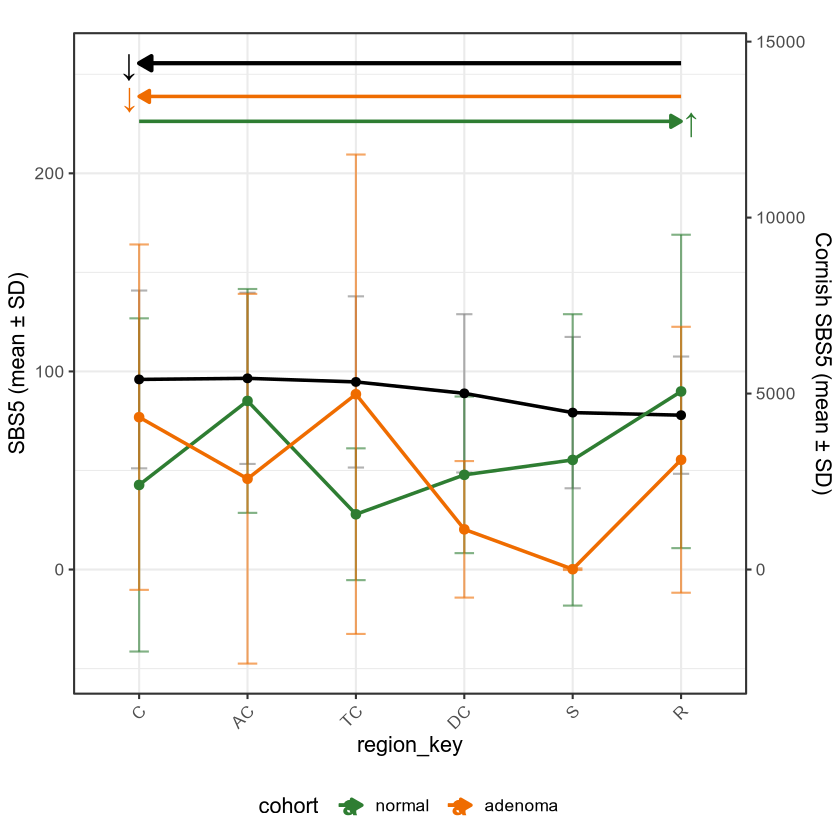

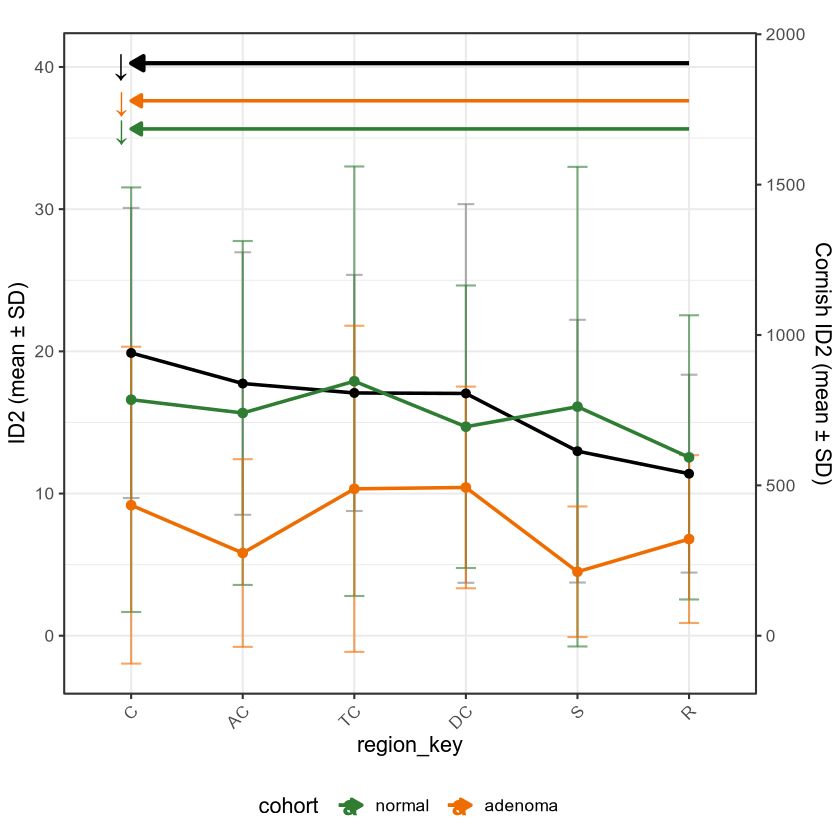

In [58]:
df_long <- df_base %>%
  pivot_longer(
    cols = all_of(plot_columns),
    names_to = "signature",
    values_to = "value"
  )

plot_faceted_signature_page <- function(signature_name, cornish_df) {

  df_sig <- df_long %>%
    filter(signature == signature_name)

  summary_sig <- df_sig %>%
    group_by(region, cohort) %>%
    summarise(
      mean = mean(value, na.rm = TRUE),
      sd   = sd(value, na.rm = TRUE),
      .groups = "drop"
    )

  # ----------------------------------
  # Cornish scaling
  # ----------------------------------
  max_you     <- max(summary_sig$mean, na.rm = TRUE)
  max_cornish <- max(cornish_df$Cornish_Mean, na.rm = TRUE)

  scale_factor <- ifelse(
    is.na(max_you) | max_you <= 0,
    1,
    pmax(1, max_cornish / max_you * 0.9)
  )

  cornish_df <- cornish_df %>%
    mutate(
      Cornish_Mean_scaled = Cornish_Mean / scale_factor,
      Cornish_SD_scaled   = Cornish_SD   / scale_factor,
      region_key = factor(region_key, levels = region_levels)
    )

  # ----------------------------------
  # Arrow height: above *all* error bars
  # ----------------------------------
  max_cohort <- max(summary_sig$mean + summary_sig$sd, na.rm = TRUE)
  max_corn   <- max(
    cornish_df$Cornish_Mean_scaled + cornish_df$Cornish_SD_scaled,
    na.rm = TRUE
  )

  y_arrow_base <- max(max_cohort, max_corn)

  # ----------------------------------
  # Direction arrows: cohorts
  # ----------------------------------
  arrow_df <- summary_sig %>%
    mutate(region_num = as.numeric(region)) %>%
    group_by(cohort) %>%
    summarise(
      slope = coef(lm(mean ~ region_num))[2],
      .groups = "drop"
    ) %>%
    mutate(
      direction = ifelse(slope > 0, "up", "down"),
      x_from = ifelse(direction == "up",
                      region_levels[1],
                      region_levels[length(region_levels)]),
      x_to   = ifelse(direction == "up",
                      region_levels[length(region_levels)],
                      region_levels[1]),
      y = y_arrow_base * case_when(
        cohort == "normal"  ~ 1.08,
        cohort == "adenoma" ~ 1.14,
        TRUE                ~ 1.08
      )
    )

  # ----------------------------------
  # Cornish direction arrow
  # ----------------------------------
  cornish_arrow <- cornish_df %>%
    mutate(region_num = as.numeric(region_key)) %>%
    summarise(
      slope = coef(lm(Cornish_Mean ~ region_num))[2]
    ) %>%
    mutate(
      direction = ifelse(slope > 0, "up", "down"),
      x_from = ifelse(direction == "up",
                      region_levels[1],
                      region_levels[length(region_levels)]),
      x_to   = ifelse(direction == "up",
                      region_levels[length(region_levels)],
                      region_levels[1]),
      y = y_arrow_base * 1.22
    )

  # ----------------------------------
  # Plot
  # ----------------------------------
  p <- ggplot(summary_sig, aes(x = region, y = mean, color = cohort)) +

    ## ---- Cornish error bars (back) ----
    geom_errorbar(
      data = cornish_df,
      aes(
        x = region_key,
        ymin = Cornish_Mean_scaled - Cornish_SD_scaled,
        ymax = Cornish_Mean_scaled + Cornish_SD_scaled
      ),
      inherit.aes = FALSE,
      width = 0.15,
      linewidth = 0.6,
      alpha = 0.6,
      color = "grey50"
    ) +

    ## ---- Cohort error bars (back) ----
    geom_errorbar(
      aes(
        ymin = mean - sd,
        ymax = mean + sd,
        group = cohort
      ),
      width = 0.18,
      linewidth = 0.6,
      alpha = 0.6
    ) +

    ## ---- Cornish mean line + points ----
    geom_line(
      data = cornish_df,
      aes(x = region_key, y = Cornish_Mean_scaled, group = 1),
      inherit.aes = FALSE,
      color = "black",
      linewidth = 1
    ) +
    geom_point(
      data = cornish_df,
      aes(x = region_key, y = Cornish_Mean_scaled),
      inherit.aes = FALSE,
      color = "black",
      size = 2
    ) +

    ## ---- Cohort trend lines + points ----
    geom_line(aes(group = cohort), linewidth = 1) +
    geom_point(size = 2.2) +

    ## ---- Cohort arrows ----
    geom_segment(
      data = arrow_df,
      aes(x = x_from, xend = x_to, y = y, yend = y, color = cohort),
      arrow = arrow(length = unit(0.25, "cm"), type = "closed"),
      linewidth = 1,
      inherit.aes = FALSE
    ) +
    geom_text(
      data = arrow_df,
      aes(
        x = x_to,
        y = y,
        label = ifelse(direction == "up", "↑", "↓"),
        color = cohort
      ),
      hjust = ifelse(arrow_df$direction == "up", -0.2, 1.2),
      size = 6,
      fontface = "bold",
      inherit.aes = FALSE
    ) +

    ## ---- Cornish arrow (top) ----
    geom_segment(
      data = cornish_arrow,
      aes(x = x_from, xend = x_to, y = y, yend = y),
      arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
      linewidth = 1.2,
      color = "black",
      inherit.aes = FALSE
    ) +
    geom_text(
      data = cornish_arrow,
      aes(
        x = x_to,
        y = y,
        label = ifelse(direction == "up", "↑", "↓")
      ),
      hjust = ifelse(cornish_arrow$direction == "up", -0.2, 1.2),
      size = 6.5,
      fontface = "bold",
      color = "black",
      inherit.aes = FALSE
    ) +

    scale_color_manual(
      values = c(
        normal  = "#2E7D32",  # green
        adenoma = "#EF6C00"   # orange
      )
    ) +

    scale_x_discrete(
      limits = region_levels,
      labels = c(
        "cecum"="C","asc_col"="AC","HF"="HC",
        "trans_col"="TC","SF"="SF","desc_col"="DC",
        "sig_col"="S","RS"="RS","rectum"="R"
      )
    ) +

    scale_y_continuous(
      name = paste0(signature_name, " (mean ± SD)"),
      sec.axis = sec_axis(
        ~ . * scale_factor,
        name = paste0("Cornish ", signature_name, " (mean ± SD)")
      )
    ) +

    coord_cartesian(clip = "off") +
    theme_bw(base_size = 13) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom",
      plot.margin = margin(t = 20, r = 5, b = 5, l = 5)
    )

  print(p)
}


plot_faceted_signature_page("SBS1",  Cornish_SBS1)
plot_faceted_signature_page("SBS5",  Cornish_SBS5)
plot_faceted_signature_page("ID2",  Cornish_ID2)
